In [77]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import locale
from datetime import datetime
from transformers import pipeline


# Set matplotlib to use English for dates
try:
    locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')
except locale.Error:
    locale.setlocale(locale.LC_TIME, 'C')

# Load and Prepare Data
df = pd.read_csv("../data/comments_post.csv")

# Basic cleaning and filtering
df = df[df["text_comment"].notna() & (df["playCount"] > 0)].copy()
df["text_comment"] = df["text_comment"].astype(str).str.lower()
df["createTimeISO"] = pd.to_datetime(df["createTimeISO"])

# Filter to last 6 months
six_months_ago = pd.Timestamp(datetime.today() - pd.DateOffset(months=6), tz="UTC")
df = df[df["createTimeISO"] >= six_months_ago]

# Add week column
df["week"] = df["createTimeISO"].dt.to_period("W").dt.start_time

C:\Users\Surface\AppData\Local\Temp\ipykernel_20832\3560241292.py:18: DtypeWarning: Columns (12,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/comments_post.csv")
C:\Users\Surface\AppData\Local\Temp\ipykernel_20832\3560241292.py:30: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["week"] = df["createTimeISO"].dt.to_period("W").dt.start_time


Definition of ingredients

In [78]:
# Define a mapping of synonyms (EN/DE) to unified ingredient names
ingredient_map = {
    "hyaluronic acid": ["hyaluronic acid", "hyaluronsäure"],
    "glycerin": ["glycerin"],
    "panthenol": ["panthenol"],
    "squalane": ["squalane", "squalan"],
    "aloe vera": ["aloe vera"],
    "niacinamide": ["niacinamide", "niacinamid"],
    "vitamin c": ["vitamin c"],
    "alpha arbutin": ["alpha arbutin", "alpha-arbutin"],
    "licorice root": ["licorice root", "lakritzextrakt"],
    "kojic acid": ["kojic acid", "kojicsäure"],
    "retinol": ["retinol"],
    "peptides": ["peptides", "peptide"],
    "bakuchiol": ["bakuchiol"],
    "coenzyme q10": ["coenzyme q10", "coenzym q10"],
    "ceramides": ["ceramides", "ceramide"],
    "salicylic acid": ["salicylic acid", "salicylsäure"],
    "glycolic acid": ["glycolic acid", "glycolsäure"],
    "lactic acid": ["lactic acid", "milchsäure"],
    "pha": ["pha"],
    "benzoyl peroxide": ["benzoyl peroxide", "benzoylperoxid"],
    "centella asiatica": ["centella asiatica", "tigergras"],
    "green tea": ["green tea", "grüner tee"],
    "allantoin": ["allantoin"],
    "calendula": ["calendula", "ringelblume"],
    "chamomile": ["chamomile", "kamille"]
}

Matching ingredients in comments

In [79]:
def find_ingredient(comment_text):
    if pd.isnull(comment_text):
        return []
    matched = set()
    for canonical, synonyms in ingredient_map.items():
        for term in synonyms:
            if re.search(rf"(?<!\w){re.escape(term)}(?!\w)", comment_text):
                matched.add(canonical)
                break
    return list(matched)

df["matched_ingredients"] = df["text_comment"].apply(find_ingredient)

Time Series Analysis - top ingredients in comments

<Figure size 1400x600 with 0 Axes>

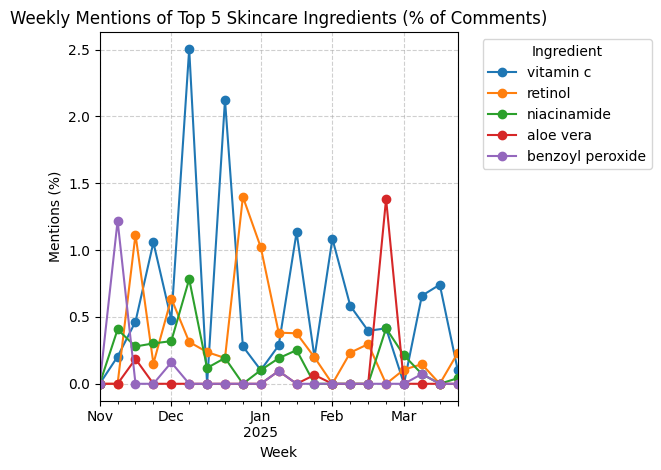

In [80]:
# Build flat list for ingredient/week counts
ingredient_mentions = []
for _, row in df[["week", "matched_ingredients"]].dropna().iterrows():
    for ingredient in row["matched_ingredients"]:
        ingredient_mentions.append((row["week"], ingredient))

df_mentions = pd.DataFrame(ingredient_mentions, columns=["week", "ingredient"])

# Weekly counts
weekly_counts = df_mentions.groupby(["week", "ingredient"]).size().reset_index(name="mention_count")

# Total comments per week
comments_per_week = df.groupby("week")["text_comment"].count().reset_index(name="total_comments")

# Merge and normalize
weekly_counts = weekly_counts.merge(comments_per_week, on="week", how="left")
weekly_counts["mention_percent"] = (weekly_counts["mention_count"] / weekly_counts["total_comments"]) * 100

# Pivot and plot top 5
pivot_df = weekly_counts.pivot(index="week", columns="ingredient", values="mention_percent").fillna(0)
top_5 = pivot_df.sum().sort_values(ascending=False).head(5).index
pivot_df = pivot_df[top_5]

plt.figure(figsize=(14, 6))
pivot_df.plot(marker="o")
plt.title("Weekly Mentions of Top 5 Skincare Ingredients (% of Comments)")
plt.xlabel("Week")
plt.ylabel("Mentions (%)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Ingredient", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

Aggregate Stats (absolute + normalized mentions)

In [81]:
normalized_mentions = (
    weekly_counts.groupby("ingredient")["mention_percent"]
    .sum()
    .reset_index()
    .rename(columns={"mention_percent": "mention_percent_total"})
)

absolute_counts = (
    df_mentions.groupby("ingredient")
    .size()
    .reset_index(name="mention_count")
)

ingredient_stats_full = pd.merge(absolute_counts, normalized_mentions, on="ingredient", how="left")
ingredient_stats_full = ingredient_stats_full.sort_values(by="mention_count", ascending=False).reset_index(drop=True)

print("Normalized Ingredient Stats:")
print(ingredient_stats_full.head(20))

Normalized Ingredient Stats:
           ingredient  mention_count  mention_percent_total
0           vitamin c            108              12.815918
1             retinol             71               7.038381
2         niacinamide             29               3.688334
3           aloe vera             14               1.730738
4     hyaluronic acid             14               1.230049
5           bakuchiol             10               1.451606
6    benzoyl peroxide              9               1.547811
7           ceramides              7               0.687046
8           panthenol              7               1.177826
9            peptides              7               0.760052
10      glycolic acid              6               0.535915
11          green tea              6               0.552503
12     salicylic acid              6               0.647394
13           glycerin              5               0.378624
14                pha              4               0.355899
15  centell

Engagement Analysis (for ingredients with ≥20 mentions)

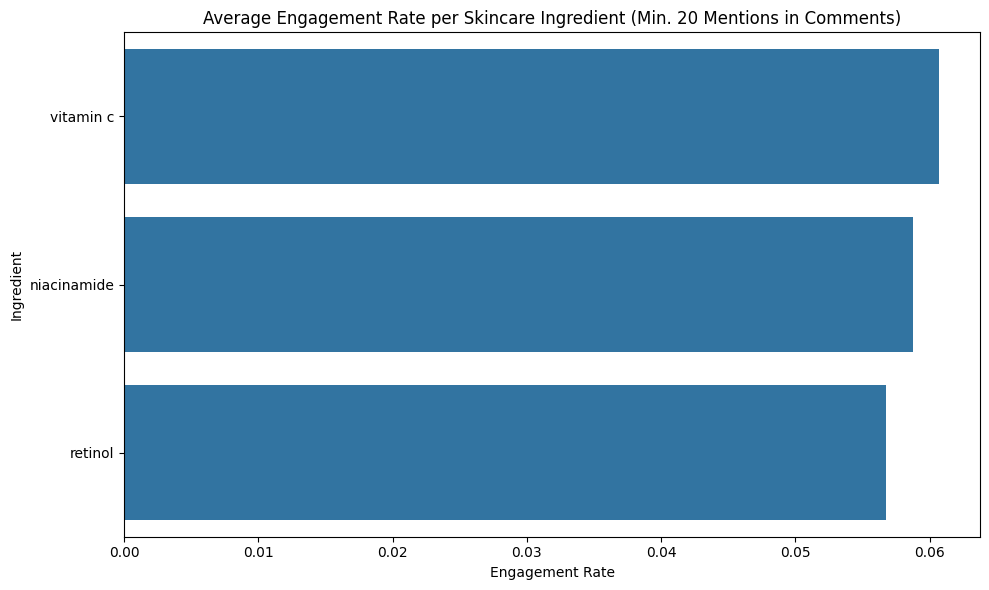

In [82]:
df_filtered = df[df["matched_ingredients"].str.len() > 0].copy()
df_filtered["engagement_rate"] = (
    df_filtered["diggCount"] + df_filtered["commentCount"] + df_filtered["shareCount"]
) / df_filtered["playCount"]

df_exploded = df_filtered.explode("matched_ingredients")

ingredient_counts = (
    df_exploded.groupby("matched_ingredients")
    .size()
    .reset_index(name="mention_count")
)

valid_ingredients = ingredient_counts[ingredient_counts["mention_count"] >= 20]["matched_ingredients"]
df_exploded_filtered = df_exploded[df_exploded["matched_ingredients"].isin(valid_ingredients)]

ingredient_stats = (
    df_exploded_filtered.groupby("matched_ingredients")["engagement_rate"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.barplot(data=ingredient_stats, x="engagement_rate", y="matched_ingredients")
plt.title("Average Engagement Rate per Skincare Ingredient (Min. 20 Mentions in Comments)")
plt.xlabel("Engagement Rate")
plt.ylabel("Ingredient")
plt.tight_layout()
plt.show()

Sentiment analysis per ingredient

In [92]:
sentiment_pipe = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment-latest", batch_size=32)

# Sentiment function
def analyze_sentiment(text):
    try:
        result = sentiment_pipe(text, truncation=True, max_length=512)[0]
        return pd.Series({
            "sentiment": result["label"],
            "confidence": result["score"]
        })
    except Exception:
        return pd.Series({
            "sentiment": "error",
            "confidence": 0.0
        })

# Apply only on rows with matched ingredients
df_sentiment = df[df["matched_ingredients"].str.len() > 0].copy()
df_sentiment[["sentiment", "confidence"]] = df_sentiment["text_comment"].apply(analyze_sentiment)

# Explode to 1 row per ingredient
df_sentiment_exploded = df_sentiment.explode("matched_ingredients")

# Group by ingredient and sentiment
ingredient_sentiment = (
    df_sentiment_exploded.groupby(["matched_ingredients", "sentiment"])
    .size()
    .reset_index(name="count")
)

# Pivot for wide format
ingredient_sentiment_pivot = ingredient_sentiment.pivot(
    index="matched_ingredients", columns="sentiment", values="count"
).fillna(0)

# Absolute total mentions
ingredient_sentiment_pivot["total_mentions"] = ingredient_sentiment_pivot.sum(axis=1)

# Normalize to percentage
ingredient_sentiment_pct = ingredient_sentiment_pivot.div(ingredient_sentiment_pivot["total_mentions"], axis=0) * 100

# Re-attach the absolute counts as a column (not normalized)
ingredient_sentiment_pct["total_mentions"] = ingredient_sentiment_pivot["total_mentions"]

# Sort by total_mentions
ingredient_sentiment_pct = ingredient_sentiment_pct.sort_values(by="total_mentions", ascending=False)

# Show top 30
ingredient_sentiment_pct.head(30)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


sentiment,negative,neutral,positive,total_mentions
matched_ingredients,,,,
vitamin c,9.259259,61.111111,29.629630,108.0
retinol,16.901408,64.788732,18.309859,71.0
niacinamide,20.689655,72.413793,6.896552,29.0
aloe vera,7.142857,42.857143,50.000000,14.0
hyaluronic acid,35.714286,57.142857,7.142857,14.0
bakuchiol,10.000000,30.000000,60.000000,10.0
benzoyl peroxide,44.444444,33.333333,22.222222,9.0
ceramides,0.000000,71.428571,28.571429,7.0
panthenol,42.857143,42.857143,14.285714,7.0


Plot sentiment analysis

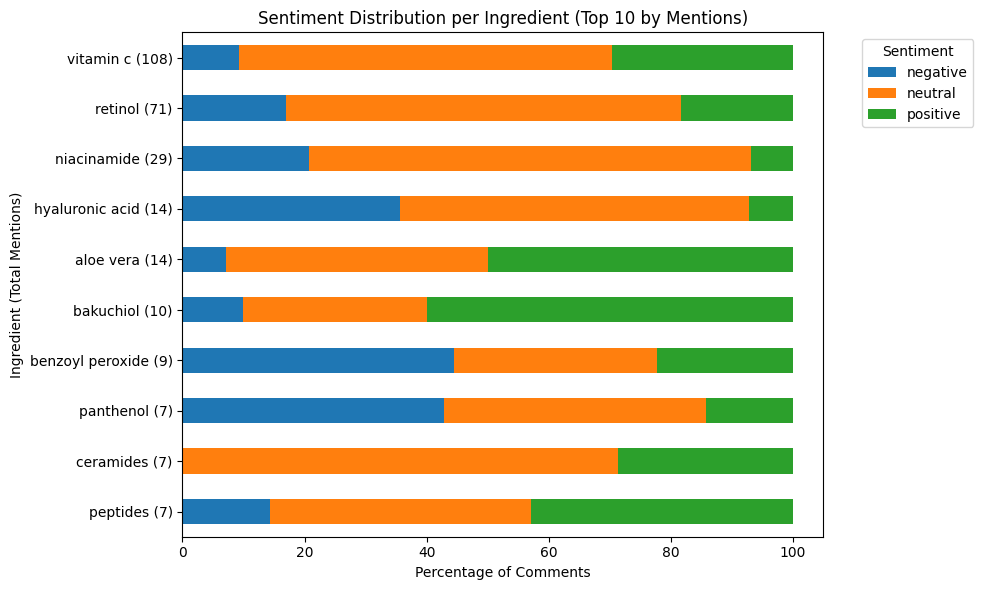

In [91]:
# Select top 10 ingredients based on total_mentions
top_ingredients = ingredient_sentiment_pct.sort_values(by="total_mentions", ascending=False).head(10)

# Sort left-to-right by total_mentions
top_ingredients = top_ingredients.sort_values(by="total_mentions", ascending=True)

# Create new index labels with total mention count
renamed_index = [
    f"{ingredient} ({int(total)})"
    for ingredient, total in zip(top_ingredients.index, top_ingredients["total_mentions"])
]

# Select only sentiment columns (exclude total_mentions)
sentiment_cols = [col for col in top_ingredients.columns if col not in ["total_mentions"]]

# Re-assign index to include mention count in labels
top_ingredients_sentiments = top_ingredients[sentiment_cols]
top_ingredients_sentiments.index = renamed_index

# Plot stacked bar chart
top_ingredients_sentiments.plot(kind="barh", stacked=True, figsize=(10, 6))  # horizontal for better label fit
plt.title("Sentiment Distribution per Ingredient (Top 10 by Mentions)")
plt.xlabel("Percentage of Comments")
plt.ylabel("Ingredient (Total Mentions)")
plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


Representative comments per sentiment and ingredient

In [94]:
# Step 1: Filter to valid sentiments only
df_sentiment_clean = df_sentiment_exploded[
    df_sentiment_exploded["sentiment"].isin(["positive", "neutral", "negative"])
]

# Step 2: Get ingredients with >20 mentions
ingredient_counts = df_sentiment_clean["matched_ingredients"].value_counts()
frequent_ingredients = ingredient_counts[ingredient_counts > 20].index

# Step 3: Filter to those frequent ingredients only
df_sentiment_clean = df_sentiment_clean[df_sentiment_clean["matched_ingredients"].isin(frequent_ingredients)]

# Step 4: Select one top-confidence comment per ingredient & sentiment
example_comments = (
    df_sentiment_clean.sort_values(by="confidence", ascending=False)
    .groupby(["matched_ingredients", "sentiment"])
    .first()
    .reset_index()[["matched_ingredients", "sentiment", "text_comment", "confidence"]]
)

# Optional: sort for easier readability
example_comments = example_comments.sort_values(by=["matched_ingredients", "sentiment"])

# Show the result
example_comments.head(30)


,matched_ingredients,sentiment,text_comment,confidence
0,niacinamide,negative,my skin hate niacinamide 🧢,0.914544
1,niacinamide,neutral,can i use it with the ordinary niacinamide?,0.924256
2,niacinamide,positive,i am using anua niacinamide and madacascar cen...,0.962521
3,retinol,negative,retinol damaged my skin barrier and gives me p...,0.918552
4,retinol,neutral,retinol??? which one do you rec?,0.948808
5,retinol,positive,so honored to be your retinol ❤️❤️❤️❤️,0.986338
6,vitamin c,negative,vitamin c is always way too expensive ☹️,0.918800
7,vitamin c,neutral,is it ok to have a vitamin c serum combined wi...,0.934136
8,vitamin c,positive,that's vitamin c i will invest in 🌸🌸🌸 love it 🎀🎀🎀,0.988166
